#Semantic Segmentation

https://huggingface.co/mattmdjaga/segformer_b2_clothes

Caso de uso: segmentación de ropa.

Ejemplos: modelos de zara

![](https://miro.medium.com/v2/resize:fit:786/format:webp/1*ePDVAObHJ2LXEiBPzvh5Qg.png)


In [1]:
!pip install numpy==1.23.5
!pip install matplotlib==3.7.1

!pip install torch==2.1.1
!pip install transformers==4.36.2
!pip install Pillow==9.4.0


!pip install gradio==4.14.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

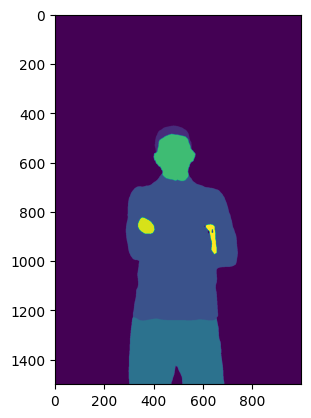

In [4]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"

image = Image.open(requests.get(url,stream=True).raw)

inputs = processor(images=image, return_tensors='pt')

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

from PIL import Image
from torch import nn

def segment_image(image):
  image = Image.fromarray(image)

  inputs = processor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits.cpu()
  upsampled_logits = nn.functional.interpolate(
          logits,
          size=image.size[::-1],
          mode="bilinear",
          align_corners=False,
      )
  pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

  colormap = plt.get_cmap('tab20').colors  # 'tab20' has 20 distinct colors
  colormap = np.array(colormap) * 255  # Convert to 0-255 range


  colored_seg = np.zeros((*pred_seg.shape, 3), dtype=np.uint8)
  for label in range(18):  # 0 to 17 inclusive
      colored_seg[pred_seg == label] = colormap[label]
  return colored_seg

gr_image_input = gr.Image(image_mode='RGB', type='numpy')
gr_image_output = gr.Image(type='numpy', label='Segmented Image')

demo = gr.Interface(fn=segment_image, inputs=gr_image_input, outputs=gr_image_output)

In [7]:
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a56c0b8ea3ce846cec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
